### LOGISTIC REGRESSION
In this assignment we try to find a relation between average weight of granules and total surface area to see if a material is viable as a catalyst

In [13]:
# LOGISTIC REGRESSION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Feature mapping
Sometimes, we are given an inadequate number of features for which training the dataset becomes difficult.  
Hence we create new features of by taking polynomial products of existing ones.

In [14]:
# Generates new features by taking products of various powers of the input features (x and y)
# This expands the feature space with polynomial combinations (up to degree 4) of x and y
def feature_map(points):
    points = np.array(points)
    x, y = points[:, 0], points[:, 1]

    features = [np.ones_like(x)]  # Bias term
    for i in range(1, 5):  # Degree 1 to 4
        for j in range(i + 1):
            features.append((x ** (i - j)) * (y ** j))

    return np.column_stack(features)


### Creating the class for Logistic Regression

In [15]:
class LogisticRegression:
    def __init__(self) -> None:
        self.weights: np.ndarray | None = None
        self.bias: float | None = None

    # Sigmoid function (TODO 2)
    def __sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-z))

    # Predict probabilities (TODO 3)
    def predict_probability(self, X: np.ndarray) -> np.ndarray:
        z = np.dot(X, self.weights) + self.bias
        return self.__sigmoid(z)

    # Predict binary classes (TODO 4)
    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.predict_probability(X) >= 0.5

    # Loss with L2 regularization (TODO 5)
    def __loss(self, X: np.ndarray, y: np.ndarray, lambda_reg: float = 0) -> tuple:
        m = X.shape[0]
        y_pred = self.predict_probability(X)

        loss = -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
        loss += (lambda_reg / (2 * m)) * np.sum(self.weights ** 2)

        dw = (1 / m) * (X.T @ (y_pred - y)) + (lambda_reg / m) * self.weights
        db = (1 / m) * np.sum(y_pred - y)

        return loss, dw, db

    # Fit model using gradient descent (TODO 6)
    def fit(self, X: np.ndarray, y: np.ndarray, epochs: int = 500,
            learning_rate: float = 0.01, threshold: float = 0.0001,
            lambda_reg: float = 1) -> None:

        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        prev_loss = float('inf')

        for _ in range(epochs):
            loss, dw, db = self.__loss(X, y, lambda_reg)

            self.weights -= learning_rate * dw
            self.bias -= learning_rate * db

            if abs(prev_loss - loss) < threshold:
                break
            prev_loss = loss


In [16]:
# Importing data
df = pd.read_csv('logistic_data.csv')
data = df.to_numpy()
X = data[:, :2]
y = data[:, 2]

# Creating train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
def z_score(X: np.ndarray) -> tuple:
    x_mean = X.mean(axis=0)
    x_std = X.std(axis=0)
    x = (X - x_mean) / x_std
    return x, x_mean, x_std


In [18]:
# Normalizing the data (we use the same constants to maintain consistency)
X_train, x_mean, x_std = z_score(X_train)
X_test = (X_test - x_mean) / x_std

x_train = feature_map(X_train)
x_test = feature_map(X_test)


In [19]:
# Checking accuracy of test model
model = LogisticRegression()
model.fit(x_train, y_train, epochs=10000, learning_rate=0.1, threshold=1e-6, lambda_reg=1)

y_pred = model.predict(x_test)
accuracy = np.mean(y_pred == y_test) * 100
print(f"Your model has an accuracy of {accuracy:.2f}%")


Your model has an accuracy of 87.50%


We plot the decision boundary that the model predicts. This can be used to check for overfitting.  
If the boundary starts looking like an ameoba trying to fit every point, then it is a sign of overfitting.

In [20]:
def plot_decision_boundary(X_original, y, model, resolution=500):
    x_min, x_max = X_original[:, 0].min() - 1, X_original[:, 0].max() + 1
    y_min, y_max = X_original[:, 1].min() - 1, X_original[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    grid_original = np.c_[xx.ravel(), yy.ravel()]
    grid_expanded = feature_map(grid_original)
    Z = model.predict(grid_expanded).reshape(xx.shape)

    true_points = X_original[y == 1]
    false_points = X_original[y == 0]

    plt.scatter(true_points[:, 0], true_points[:, 1], label="True", c="blue", marker="o", s=20)
    plt.scatter(false_points[:, 0], false_points[:, 1], label="False", c="red", marker="x", s=20)
    plt.contour(xx, yy, Z, levels=[0.5], colors="black", linewidths=2)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary and Data Points")
    plt.legend()
    plt.show()


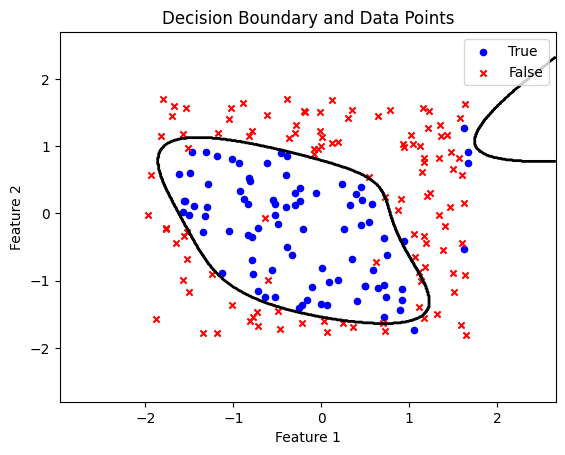

In [21]:
# Plotting the contour and checking for overfitting
plot_decision_boundary(((X - x_mean) / x_std), y, model)
